## Verificação de Algoritmos

Neste notebook serao testadas tecnicas mais tradicionais para classificacao das mensagens. Testado um treinamento nao supervisionado usando o Spectral Clustering, e tambem um treinamento supervisionado usando alguns algoritmos classificadores.

In [1]:
import os
import sys

sys.path.append(f"{os.getcwd()}/../")

In [2]:
import time
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.metrics.pairwise import (
    cosine_similarity, 
    cosine_distances,
    laplacian_kernel, 
    euclidean_distances, 
    sigmoid_kernel, 
    chi2_kernel,
    polynomial_kernel,
    rbf_kernel
)
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, v_measure_score, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.cluster import SpectralClustering

from processing.utils import CleanUp, RSLP_STEMMER, SNOWBALL_STEMMER, NLP_LEMMATIZER

%matplotlib inline

clean_up = CleanUp(stemmer=SNOWBALL_STEMMER)

In [3]:
df = pd.read_csv(f"{os.getcwd()}/../../data/dataset.csv", sep="|")
df["x"] = df["comentario"].apply(lambda comment: clean_up.fit(str(comment)))
df["y"] = df["classificacao"].apply(lambda clasf: 0 if clasf == "negativo" else 1)
textos = df[["x", "y"]].to_numpy()

In [4]:
print(random.choice(textos))
print(len(textos))
# print(df[df['x'] == ''].index)
# print(df.loc[250])

['vou morr dor gargant' 1]
2197


### Unsupervised Learning : Spectral Clustering

Baseado no paper de referência: [Opinion Mining on Twitter Data using Unsupervised Learning Technique](https://www.ijcaonline.org/archives/volume148/number12/unnisa-2016-ijca-911317.pdf)

In [5]:
start = time.time()

validacoes = []
for Vectorizer, Norm in [(CountVectorizer, StandardScaler), (CountVectorizer, None), (TfidfVectorizer, None)]:
    for ngram_range in [(1, 1), (1, 2), (1, 3), (3, 3)]:
        vectorizer = Vectorizer(ngram_range=ngram_range)
        X = vectorizer.fit_transform(textos[:, 0])
        norm_name = None
        if Norm:
            norm_name = Norm.__name__
            X = Norm(with_mean=False).fit_transform(X)
        y = textos[:, 1].astype(np.int).ravel()

        for metric in (
            cosine_distances,
            euclidean_distances, 
            sigmoid_kernel, 
            polynomial_kernel,
            rbf_kernel,
            # Usam apenas 1 cpu para calcular... muito lento
            # laplacian_kernel, 
            # chi2_kernel,
        ):
            for assign_labels in ["discretize", "kmeans"]:
                clustering = SpectralClustering(
                    n_clusters=2,
                    eigen_solver="amg",
                    assign_labels=assign_labels,
                    affinity="precomputed_nearest_neighbors",
                    random_state=0,
                    n_jobs=-1
                ).fit(metric(X))

                pred = clustering.labels_
                acc = round(accuracy_score(pred, y) * 100, 2)
                f1 = round(f1_score(pred, y) * 100, 2)
                vm = round(v_measure_score(y, pred), 2)
                validacoes.append((
                    vectorizer.__class__.__name__,
                    norm_name,
                    ngram_range,
                    metric.__name__,
                    assign_labels,
                    acc, 
                    f1,
                    vm
                ))

print(time.time() - start)

69.83062100410461


In [6]:
columns = ["Vectorizer", "Scaler", "NGram", "Metric", "AssignLabels", "Accuracy", "F1", "V-Measure"]
df = pd.DataFrame(validacoes, columns=columns)
df = df.sort_values(by=["F1", "Accuracy", "V-Measure", "Vectorizer", "Metric"], ascending=False)
df.head(25)

,Vectorizer,Scaler,NGram,Metric,AssignLabels,Accuracy,F1,V-Measure
58,CountVectorizer,None,"(1, 2)",rbf_kernel,discretize,42.06,56.00,0.0
55,CountVectorizer,None,"(1, 2)",sigmoid_kernel,kmeans,46.24,49.03,0.0
57,CountVectorizer,None,"(1, 2)",polynomial_kernel,kmeans,46.24,49.03,0.0
65,CountVectorizer,None,"(1, 3)",sigmoid_kernel,kmeans,46.79,48.89,0.0
67,CountVectorizer,None,"(1, 3)",polynomial_kernel,kmeans,46.79,48.89,0.0
64,CountVectorizer,None,"(1, 3)",sigmoid_kernel,discretize,46.97,47.87,0.0
66,CountVectorizer,None,"(1, 3)",polynomial_kernel,discretize,46.97,47.87,0.0
45,CountVectorizer,None,"(1, 1)",sigmoid_kernel,kmeans,46.06,47.82,0.0
47,CountVectorizer,None,"(1, 1)",polynomial_kernel,kmeans,46.06,47.82,0.0
54,CountVectorizer,None,"(1, 2)",sigmoid_kernel,discretize,46.93,47.29,0.0


              precision    recall  f1-score   support

           0       0.60      0.97      0.74      1321
           1       0.34      0.02      0.04       876

    accuracy                           0.59      2197
   macro avg       0.47      0.50      0.39      2197
weighted avg       0.50      0.59      0.46      2197



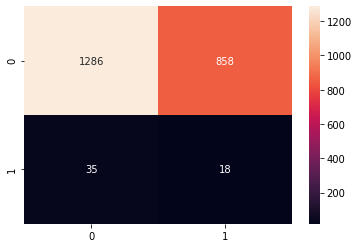

In [7]:
vectorizer = CountVectorizer(ngram_range=(1, 3))
X = vectorizer.fit_transform(textos[:, 0])
X = StandardScaler(with_mean=False).fit_transform(X)
y = textos[:, 1].astype(np.int).ravel()

clustering = SpectralClustering(
    n_clusters=2,
    eigen_solver="amg",
    assign_labels="kmeans",
    affinity="precomputed_nearest_neighbors",
    random_state=0,
    n_jobs=-1
).fit(rbf_kernel(X))
pred = clustering.labels_

print(classification_report(y, pred))

df_cm = confusion_matrix(pred, y)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.show()

### Supervised Learning

Parcialmente baseado no paper: [Towards detecting influenza epidemics by analyzing Twitter messages](https://dl.acm.org/doi/pdf/10.1145/1964858.1964874)

In [8]:
start = time.time()

classifiers = [
    ("LogisticRegression", LogisticRegression(
        random_state=0,
        max_iter=1000,
        multi_class="ovr",
        n_jobs=-1
    )), 
    ("SGDClassifier", SGDClassifier(
        alpha=1e-5,
        random_state=0,
        n_jobs=-1,
        max_iter=5000,
        n_iter_no_change=100
    )), 
    ("SVC_Linear", SVC(kernel="linear", C=5, random_state=0)),
    ("SVC_Linear_2", SVC(kernel="linear", C=0.025, random_state=0)),
    ("SVC_RBF", SVC(gamma=2, C=1, random_state=0)),
]

validacoes = []
for Vectorizer, Norm in [(CountVectorizer, StandardScaler), (CountVectorizer, None), (TfidfVectorizer, None)]:
    for ngram_range in [(1, 1), (1, 2), (1, 3)]:
        vectorizer = Vectorizer(ngram_range=ngram_range)
        X = vectorizer.fit_transform(textos[:, 0])
        y = textos[:, 1].astype(np.int).ravel()
        
        norm_name = None
        if Norm:
            norm_name = Norm.__name__
            X = Norm(with_mean=False).fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        for name, Classifier in classifiers:
            clf = Classifier.fit(X_train, y_train)
            pred = clf.predict(X_test)

            acc = round(accuracy_score(pred, y_test) * 100, 2)
            f1 = round(f1_score(pred, y_test) * 100, 2)
            validacoes.append((
                vectorizer.__class__.__name__,
                norm_name,
                ngram_range,
                name,
                acc, 
                f1
            ))

print(time.time() - start)

24.64110779762268


In [9]:
columns = ["Vectorizer", "Scaler", "NGram", "Classifier", "Accuracy", "F1"]
df = pd.DataFrame(validacoes, columns=columns)
df = df.sort_values(by=["F1", "Accuracy", "Vectorizer", "NGram"], ascending=False)
df.head(25)

,Vectorizer,Scaler,NGram,Classifier,Accuracy,F1
42,TfidfVectorizer,None,"(1, 3)",SVC_Linear,78.18,69.62
20,CountVectorizer,None,"(1, 2)",LogisticRegression,74.32,69.04
41,TfidfVectorizer,None,"(1, 3)",SGDClassifier,78.18,69.03
36,TfidfVectorizer,None,"(1, 2)",SGDClassifier,76.59,68.88
22,CountVectorizer,None,"(1, 2)",SVC_Linear,72.95,68.77
37,TfidfVectorizer,None,"(1, 2)",SVC_Linear,75.68,68.44
25,CountVectorizer,None,"(1, 3)",LogisticRegression,73.41,68.29
21,CountVectorizer,None,"(1, 2)",SGDClassifier,72.73,67.57
15,CountVectorizer,None,"(1, 1)",LogisticRegression,72.95,67.40
27,CountVectorizer,None,"(1, 3)",SVC_Linear,71.14,67.18


              precision    recall  f1-score   support

           0       0.80      0.87      0.83       270
           1       0.75      0.65      0.70       170

    accuracy                           0.78       440
   macro avg       0.77      0.76      0.76       440
weighted avg       0.78      0.78      0.78       440



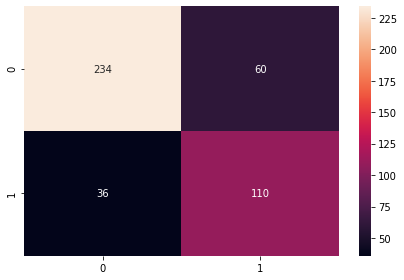

In [12]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X = vectorizer.fit_transform(textos[:, 0])
y = textos[:, 1].astype(np.int).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# clf = SGDClassifier(
#     alpha=1e-5,
#     random_state=0,
#     n_jobs=-1,
#     max_iter=5000,
#     n_iter_no_change=100
# ).fit(X_train, y_train)

clf = SVC(kernel="linear", C=5, random_state=0).fit(X_train, y_train)

pred = clf.predict(X_test)

# loss = clf.loss_curve_
# plt.plot(range(1, len(loss) + 1), loss)

print(classification_report(y_test, pred))

df_cm = confusion_matrix(pred, y_test)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.tight_layout()
plt.show()

### Supervised Learning : Ensemble

              precision    recall  f1-score   support

           0       0.73      0.93      0.82       270
           1       0.80      0.45      0.58       170

    accuracy                           0.75       440
   macro avg       0.77      0.69      0.70       440
weighted avg       0.76      0.75      0.73       440



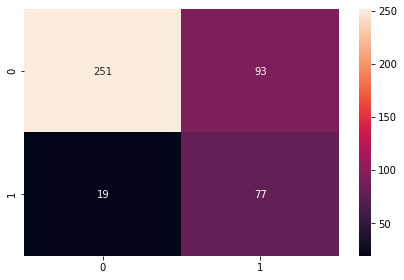

In [14]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X = vectorizer.fit_transform(textos[:, 0])
# X = StandardScaler(with_mean=False).fit_transform(X)
y = textos[:, 1].astype(np.int).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf1 = LogisticRegression(random_state=0, n_jobs=-1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=0)
clf3 = MultinomialNB()

eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('mnb', clf3)],
    voting='soft', weights=[2, 2, 1], n_jobs=-1
).fit(X_train, y_train)
pred = eclf.predict(X_test)

print(classification_report(y_test, pred))

df_cm = confusion_matrix(pred, y_test)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.tight_layout()
plt.show()